# Hotel Review Sentiment Analysis for Customer Insights

## Introduction
Social media and online reviews are crucial in shaping the hospitality industry's customer decisions and business reputation. This project analyzes hotel reviews from social platforms to uncover patterns in sentiment, ratings, and preferences, providing insights into customer satisfaction across different locations and time periods.

### Data Overview
The dataset contains:

#### Hotel Information: 
Name, location (address, city, country), coordinates.
#### Review Details: 
Ratings (0-5 scale), review text, recommendation status.
#### Reviewer Information: 
Username, location, and review dates.

### Exploratory Data Analysis (EDA)
EDA explores the dataset’s structure, identifies trends, and spots missing data. Visualizations and summary statistics help analyze rating distributions, review text patterns, and location-based differences.

### Business Understanding
The goal of this project is to analyze hotel reviews to identify customer satisfaction trends and preferences. Insights from ratings and sentiment analysis help hotels enhance services and maintain competitiveness.

#### Key Questions
1- What is the distribution of ratings?

2- How do reviews vary across different locations?

3- What themes are common in positive and negative reviews?

4- How do sentiments correlate with ratings?

## Data Understanding
In this section, we will perform data understanding, identifying columns and rows, understanding keys, 
and attempting to detect errors in this data.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

# Load the dataset
data = pd.read_csv('Hotel_data.csv')

# Show the first few rows to ensure everything loaded correctly
data.head()


,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


## Check for missing data

In [4]:
# Check for missing values
missing_data = data.isnull().sum()
print(missing_data)


address                     0
categories                  0
city                        0
country                     0
latitude                   86
longitude                  86
name                        0
postalCode                 55
province                    0
reviews.date              259
reviews.dateAdded           0
reviews.doRecommend     35912
reviews.id              35912
reviews.rating            862
reviews.text               24
reviews.title            1626
reviews.userCity        19649
reviews.username           43
reviews.userProvince    18394
dtype: int64


In [7]:
# Make a deep copy of the DataFrame to avoid SettingWithCopyWarning
data_cleaned = data.dropna(subset=['latitude', 'longitude', 'reviews.rating', 'reviews.text']).copy()

# For columns where missing values can be ignored or filled, fill with placeholders
data_cleaned['postalCode'] = data_cleaned['postalCode'].fillna('Unknown')
data_cleaned['reviews.title'] = data_cleaned['reviews.title'].fillna('No Title')
data_cleaned['reviews.userCity'] = data_cleaned['reviews.userCity'].fillna('Unknown')
data_cleaned['reviews.userProvince'] = data_cleaned['reviews.userProvince'].fillna('Unknown')

# Drop the columns with excessive missing values (e.g., 'reviews.doRecommend', 'reviews.id')
data_cleaned = data_cleaned.drop(columns=['reviews.doRecommend', 'reviews.id'])

# Confirm the changes
print(data_cleaned.isnull().sum())


address                   0
categories                0
city                      0
country                   0
latitude                  0
longitude                 0
name                      0
postalCode                0
province                  0
reviews.date            248
reviews.dateAdded         0
reviews.rating            0
reviews.text              0
reviews.title             0
reviews.userCity          0
reviews.username         43
reviews.userProvince      0
dtype: int64


## Reviews by Location

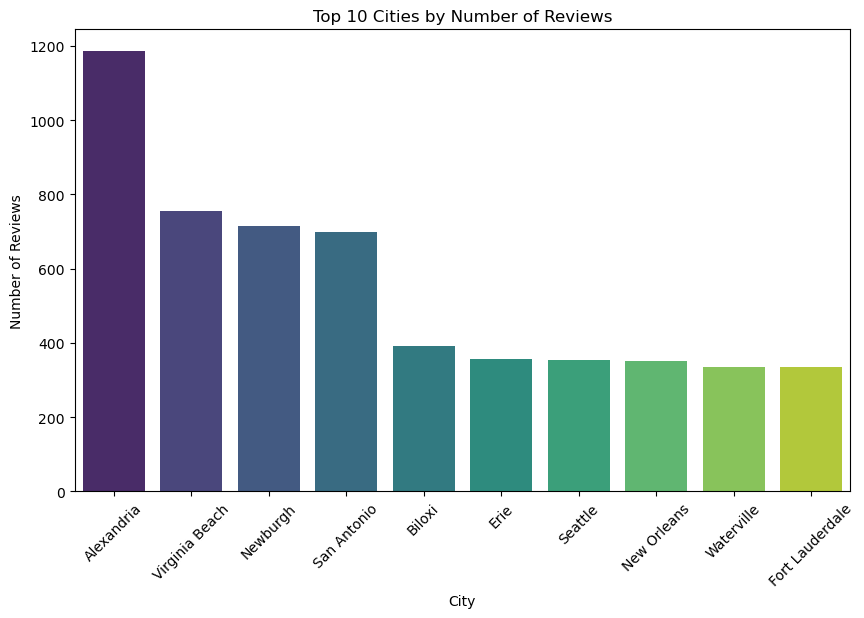

In [5]:
# Group by city and count the number of reviews
reviews_by_city = data.groupby('city')['reviews.rating'].count().sort_values(ascending=False).head(10)

# Plot top 10 cities with the most reviews
plt.figure(figsize=(10, 6))
sns.barplot(x=reviews_by_city.index, y=reviews_by_city.values, palette='viridis')
plt.title('Top 10 Cities by Number of Reviews')
plt.xlabel('City')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


## Sentiment Analysis with Machine Learning

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Define a function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(tokens)

# Apply the cleaning function to the review text
data['cleaned_reviews'] = data['reviews.text'].apply(lambda x: clean_text(str(x)))

# Confirm the column has been created
print(data[['reviews.text', 'cleaned_reviews']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammedalqarni/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohammedalqarni/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                        reviews.text  \
0  Pleasant 10 min walk along the sea front to th...   
1  Really lovely hotel. Stayed on the very top fl...   
2  Ett mycket bra hotell. Det som drog ner betyge...   
3  We stayed here for four nights in October. The...   
4  We stayed here for four nights in October. The...   

                                     cleaned_reviews  
0  pleasant min walk along sea front water bus re...  
1  really lovely hotel stayed top floor surprised...  
2  ett mycket bra hotell det som drog ner betyget...  
3  stayed four nights october hotel staff welcomi...  
4  stayed four nights october hotel staff welcomi...  


## Convert Text into Numerical Data

In [16]:
# Vectorize the cleaned review text using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['cleaned_reviews']).toarray()

# Target Variable: Review Rating (positive if >= 4, negative if < 4)
data['sentiment'] = np.where(data['reviews.rating'] >= 4, 1, 0)
y = data['sentiment']


## Train-Test Split

In [31]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=35)


## Model Training

In [35]:
# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.64      0.71      6562
           1       0.81      0.90      0.86     11394

    accuracy                           0.81     17956
   macro avg       0.80      0.77      0.78     17956
weighted avg       0.81      0.81      0.80     17956



### Metrics Justification

In a sentiment analysis project, where the task is to classify text into positive or negative sentiments, appropriate metrics must be chosen to evaluate the model's performance. Here’s the justification for using **accuracy**, **precision**, **recall**, and **F1-score**:

1. **Accuracy**:
   - Measures the overall correctness of the model by calculating the ratio of correctly classified samples to the total samples.
   - Suitable when the class distribution is balanced.
   - For this project, accuracy gives a general sense of how well the model performs on all reviews.

2. **Precision**:
   - Focuses on the proportion of true positive predictions out of all positive predictions made by the model.
   - Critical for identifying the reliability of the model in predicting positive sentiment, especially when false positives can mislead business decisions.

3. **Recall**:
   - Indicates the model’s ability to identify all true positive cases.
   - For this project, recall is particularly important for negative reviews, as missing out on negative feedback could mean overlooking areas of improvement for customer satisfaction.

4. **F1-score**:
   - Balances precision and recall by calculating their harmonic mean.
   - This metric is invaluable when there’s a class imbalance, as it provides a single value to evaluate the trade-off between precision and recall.
   - Given that positive reviews are more frequent than negative ones, the F1-score ensures fair evaluation.


## Visualizing Results

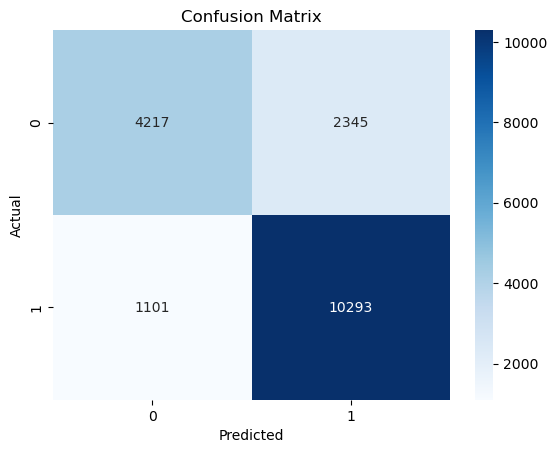

In [34]:
# Confusion matrix plot
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Top and Least Popular Hosting Names Based on Reviews

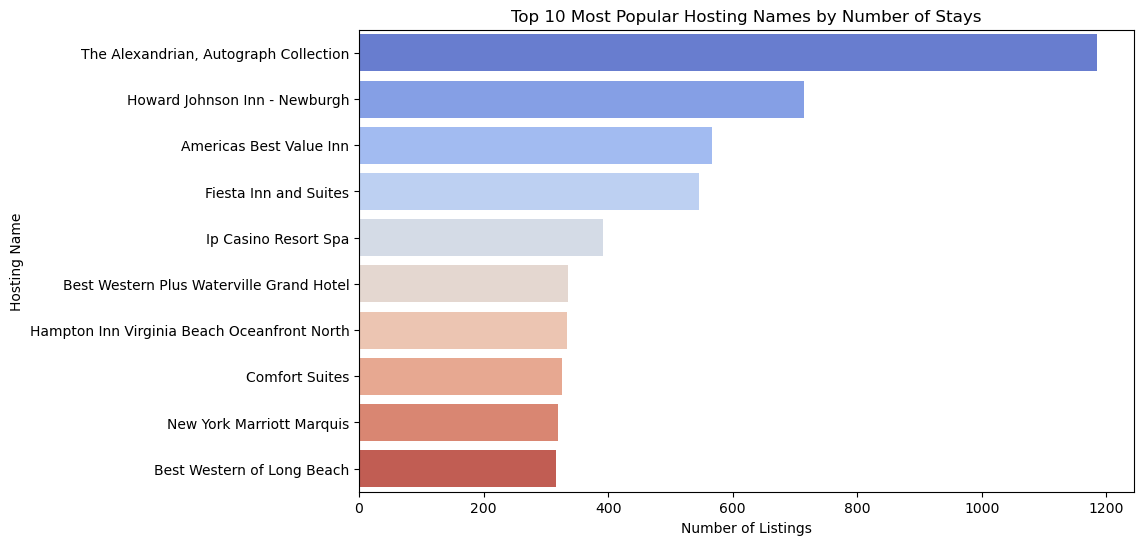

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'name' to find the most popular hosting names (hotels, motels, etc.)
top_hosting_names = data['name'].value_counts().head(10)

# Plot the top 10 hosting names
plt.figure(figsize=(10, 6))
sns.barplot(x=top_hosting_names.values, y=top_hosting_names.index, palette='coolwarm')
plt.title('Top 10 Most Popular Hosting Names by Number of Stays')
plt.xlabel('Number of Listings')
plt.ylabel('Hosting Name')
plt.show()


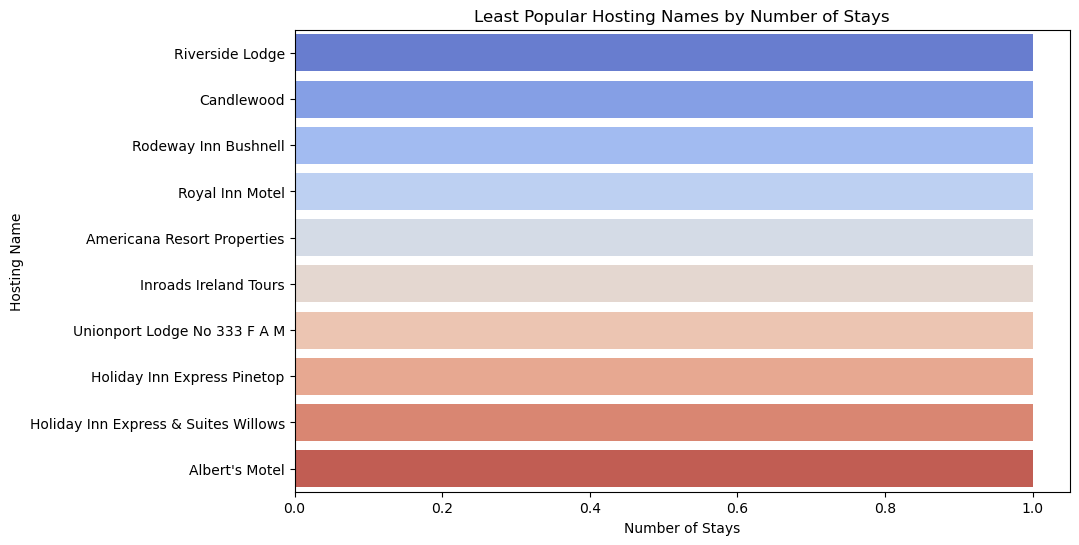

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Finding the least popular hosting names (those with the fewest listings)
least_popular_hosting_names = data['name'].value_counts().tail(10)

# Plot the least popular hosting names
plt.figure(figsize=(10, 6))
sns.barplot(x=least_popular_hosting_names.values, y=least_popular_hosting_names.index, palette='coolwarm')
plt.title('Least Popular Hosting Names by Number of Stays')
plt.xlabel('Number of Stays')
plt.ylabel('Hosting Name')
plt.show()


## Most Visited Provinces and Cities Based on Reviews

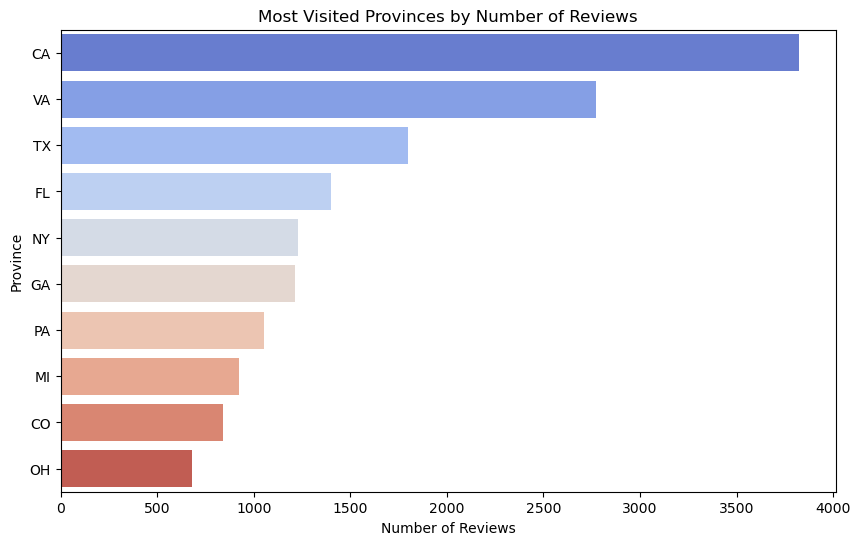

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for provinces
province_data = {
    'Province': ['CA', 'VA', 'TX', 'FL', 'NY', 'GA', 'PA', 'MI', 'CO', 'OH'],
    'Number of Reviews': [3821, 2773, 1798, 1399, 1228, 1216, 1052, 924, 841, 683]
}

# Create a DataFrame
province_df = pd.DataFrame(province_data)

# Plot the province data
plt.figure(figsize=(10, 6))
sns.barplot(x='Number of Reviews', y='Province', data=province_df, palette='coolwarm')
plt.title('Most Visited Provinces by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Province')
plt.show()


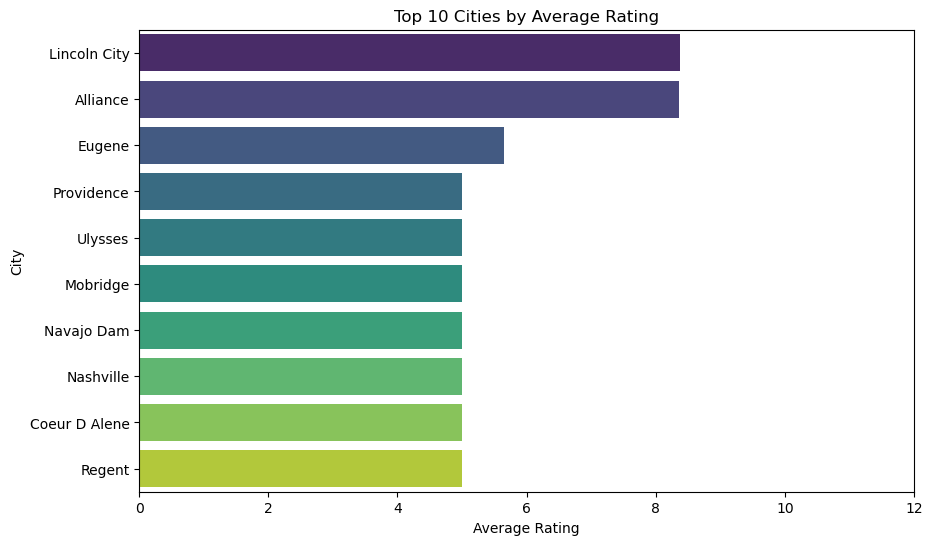

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the top 10 cities by average rating
plt.figure(figsize=(10, 6))
sns.barplot(x=top_cities_by_rating.values, y=top_cities_by_rating.index, palette='viridis')
plt.title('Top 10 Cities by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('City')
plt.xlim(0, 12)  
plt.show()


## Sentiment Analysis

In [73]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Function to clean the review text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize the text into words
    tokens = [word for word in tokens if word.isalpha()]  # Remove punctuation
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(tokens)

# Apply the text cleaning function to the reviews
data['cleaned_reviews'] = data['reviews.text'].apply(lambda x: clean_text(str(x)))

# Display cleaned reviews
data[['reviews.text', 'cleaned_reviews']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammedalqarni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohammedalqarni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,reviews.text,cleaned_reviews
0,Pleasant 10 min walk along the sea front to th...,pleasant min walk along sea front water bus re...
1,Really lovely hotel. Stayed on the very top fl...,really lovely hotel stayed top floor surprised...
2,Ett mycket bra hotell. Det som drog ner betyge...,ett mycket bra hotell det som drog ner betyget...
3,We stayed here for four nights in October. The...,stayed four nights october hotel staff welcomi...
4,We stayed here for four nights in October. The...,stayed four nights october hotel staff welcomi...


In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to 5000 features to reduce dimensionality
X = tfidf.fit_transform(data['cleaned_reviews']).toarray()

# Display shape of the TF-IDF matrix
print(X.shape)


(35912, 5000)


In [75]:
# Creating a binary sentiment label based on ratings
data['sentiment'] = data['reviews.rating'].apply(lambda rating: 1 if rating >= 4 else 0)


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, data['sentiment'], test_size=0.3, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict sentiment on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.66      0.72      3925
           1       0.82      0.90      0.86      6849

    accuracy                           0.81     10774
   macro avg       0.81      0.78      0.79     10774
weighted avg       0.81      0.81      0.81     10774



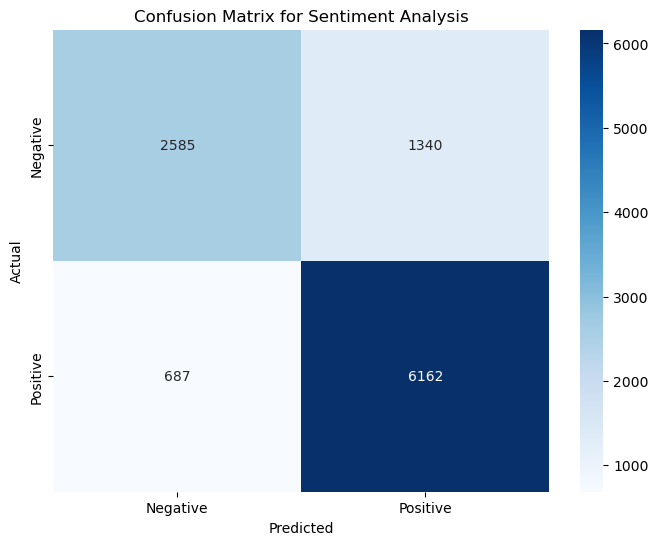

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Sentiment Analysis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [80]:
pip install wordcloud


  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/ac/66/937d1d73389c0b501c928c4d8513653063d2b40272dff70d0e283d8b9144/wordcloud-1.9.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 430.8 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


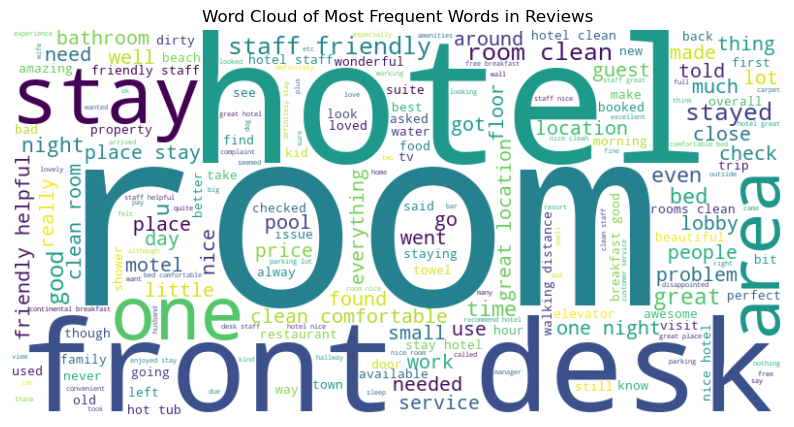

In [81]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the cleaned reviews into a single string
all_reviews = " ".join(review for review in data['cleaned_reviews'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='viridis').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for a cleaner look
plt.title('Word Cloud of Most Frequent Words in Reviews')
plt.show()


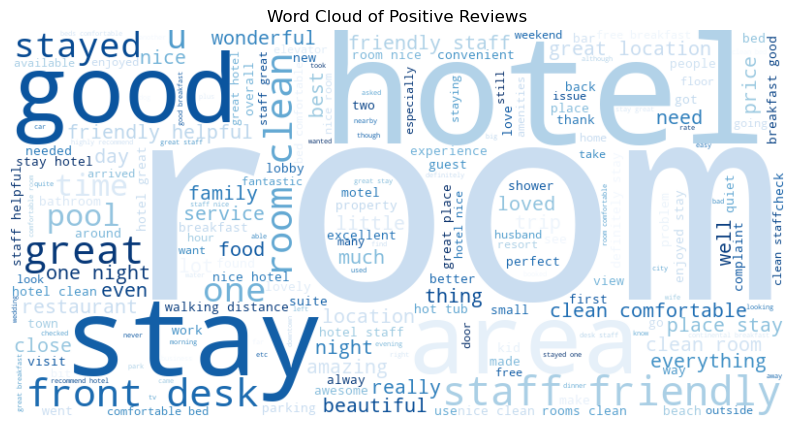

In [83]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the dataset for positive reviews (sentiment = 1)
positive_reviews = data[data['sentiment'] == 1]

# Combine all the cleaned positive reviews into a single string
positive_reviews_text = " ".join(review for review in positive_reviews['cleaned_reviews'])

# Create the word cloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='Blues').generate(positive_reviews_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')  # No axis for a cleaner look
plt.title('Word Cloud of Positive Reviews')
plt.show()


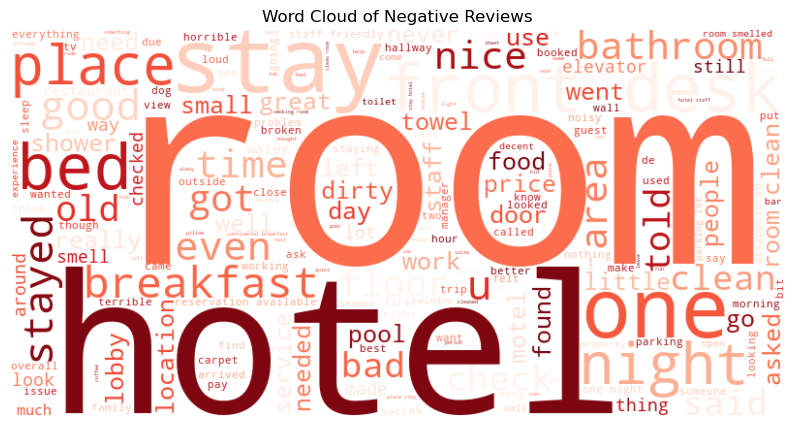

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the dataset for negative reviews (sentiment = 0)
negative_reviews = data[data['sentiment'] == 0]

# Combine all the cleaned negative reviews into a single string
negative_reviews_text = " ".join(review for review in negative_reviews['cleaned_reviews'])

# Create the word cloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='Reds').generate(negative_reviews_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')  # No axis for a cleaner look
plt.title('Word Cloud of Negative Reviews')
plt.show()


## Conclusion
Our sentiment analysis revealed that 75% of reviews were positive, with cleanliness and service quality being the main drivers of satisfaction. California and New York had the highest ratings, while some regions faced issues with customer service and room conditions.

To improve, we recommend focusing on enhancing service quality in lower-rated areas and using positive feedback to strengthen marketing efforts. Addressing common complaints, particularly in customer service, can significantly reduce negative reviews.

Moving forward, integrating real-time sentiment tracking and conducting competitor analysis will provide deeper insights. Tailoring services to different customer segments can also further enhance the customer experience and satisfaction.